# Deliverable 3: Optimize the Model

The original model will be tested with each of the following changes made independently. Weights and Model instances will be saved for each.

### Optimization Trials: 

1. Add 3rd hidden layer with 15 nodes
2. Decrease neurons in original model
3. Change activation function to Tanh
4. Increase number of bins for APPLICATION_TYPE
5. Drop APPLICATION_TYPE 
6. Additional Neurons per Layer, Additional Layer, Filter for most important Variables, Decrease bins for Class and App type.
7. Increase number of bins for CLASSIFICATION.
8. Change scaler to better match ReLU activation function, keep and bin NAME column, bin ASK_AMT, increase neurons, add 3rd layer.

Other indepent tests:
- ELU, ReLU, LeakyReLU PReLU, ThresholdedReLU, and tanh activation functions, all at 500 epochs with 4 layers - nodes: [150, 70, 30, 15]
- Adjusting bin sizing for additional features
- MinMaxScaler used to scale data
- Adam, Nadam, RMSprop, SGD optimizers
- Layer regulizers: l1, l2, l1_l2, Orthagonal
- Adjusted learning rate: .03, .05
- Removal of various features

 ### Trials 1 - 7 failed to increase accuracy above ~73%, models saved under models/*Trial_x*, weights under checkpoints/*Trial_x*
 ### Trial 8 is successful, increasing accuracy to 77.5% and decreasing loss under 57%, model is saved under models/optimized, weights under checkpoints/Trial_8


## Import dependencies and load orignial dataset

In [2]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
import tensorflow as tf
import os
from tensorflow.keras.callbacks import ModelCheckpoint

#  Import and read the charity_data.csv.
import pandas as pd 
application_df = pd.read_csv("../Resources/charity_data.csv")
application_df.head()

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


## Original Model Preprocessing

In [2]:
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
application_df = application_df.drop(columns=['EIN', "NAME"])
application_df.head()

,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [3]:
# Determine which values to replace
app_type_counts = application_df['APPLICATION_TYPE'].value_counts()
replace_application = list(app_type_counts[app_type_counts < 500].index)

# Replace in dataframe
for app in replace_application:
    application_df.APPLICATION_TYPE = application_df.APPLICATION_TYPE.replace(app,"Other")
    
# Check to make sure binning was successful
application_df.APPLICATION_TYPE.value_counts()

T3       27037
T4        1542
T6        1216
T5        1173
T19       1065
T8         737
T7         725
T10        528
Other      276
Name: APPLICATION_TYPE, dtype: int64

In [4]:
# Determine which values to replace
class_counts = application_df['CLASSIFICATION'].value_counts()
replace_class = list(class_counts[class_counts < 1500].index)

# Replace in dataframe
for cls in replace_class:
    application_df.CLASSIFICATION = application_df.CLASSIFICATION.replace(cls,"Other")
    
# Check to make sure binning was successful
application_df.CLASSIFICATION.value_counts()

C1000    17326
C2000     6074
C1200     4837
Other     2261
C3000     1918
C2100     1883
Name: CLASSIFICATION, dtype: int64

In [5]:
application_cat = application_df.dtypes[application_df.dtypes == object].index.to_list()
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(application_df[application_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names_out(application_cat)
encode_df.head()

,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,APPLICATION_TYPE_T8,AFFILIATION_CompanySponsored,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [6]:
application_df = application_df.merge(encode_df, left_index=True, right_index=True)
application_df = application_df.drop(application_cat, 1)
application_df.head()

c:\Users\jacob\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


,STATUS,ASK_AMT,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,1,5000,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,108590,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,5000,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,6692,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,142590,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [7]:
# Split our preprocessed data into our features and target arrays
y = application_df['IS_SUCCESSFUL'].values
X = application_df.drop('IS_SUCCESSFUL', 1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

c:\Users\jacob\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Original Model

In [9]:
nn_imported = tf.keras.models.load_model("../models/Original_model/AlphabetSoupCharity.h5")
model_loss, model_accuracy = nn_imported.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5754 - accuracy: 0.7236 - 327ms/epoch - 1ms/step
Loss: 0.5753867626190186, Accuracy: 0.7236151695251465


## 1. Model with 3 layers

In [10]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
n_inputs = len(X_train_scaled[0])
n_nodes_layer1 = 80
n_nodes_layer2 = 30
n_nodes_layer3 = 15
nn_3 = tf.keras.models.Sequential()

# First hidden layer
nn_3.add(tf.keras.layers.Dense(units=n_nodes_layer1, 
        input_dim=n_inputs, activation="relu"))


# Second hidden layer
nn_3.add(tf.keras.layers.Dense(units=n_nodes_layer2, 
        activation="relu"))

# Third hidden layer
nn_3.add(tf.keras.layers.Dense(units=n_nodes_layer3, 
        activation="relu"))

# Output layer
nn_3.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                3520      
                                                                 
 dense_1 (Dense)             (None, 30)                2430      
                                                                 
 dense_2 (Dense)             (None, 15)                465       
                                                                 
 dense_3 (Dense)             (None, 1)                 16        
                                                                 
Total params: 6,431
Trainable params: 6,431
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Define the checkpoint path and filenames
os.makedirs("../checkpoints/trial_1",exist_ok=True)
checkpoint_path = "../checkpoints/trial_1/weights.{epoch:02d}.hdf5"

# Compile the model
nn_3.compile(loss="binary_crossentropy", optimizer="adam", 
            metrics=["accuracy"])

# Create callback to save weights per 5epochs
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=(804*5))

# Train the model
nn_3_fit = nn_3.fit(X_train_scaled,y_train,epochs=100,
        callbacks=[cp_callback])

Epoch 1/100
804/804 [==============================] - 1s 879us/step - loss: 0.5662 - accuracy: 0.7250
Epoch 2/100
804/804 [==============================] - 1s 856us/step - loss: 0.5526 - accuracy: 0.7317
Epoch 3/100
804/804 [==============================] - 1s 852us/step - loss: 0.5495 - accuracy: 0.7324
Epoch 4/100
804/804 [==============================] - 1s 857us/step - loss: 0.5479 - accuracy: 0.7330
Epoch 5/100
762/804 [===========================>..] - ETA: 0s - loss: 0.5477 - accuracy: 0.7334
Epoch 5: saving model to ../checkpoints/trial_1\weights.05.hdf5
804/804 [==============================] - 1s 878us/step - loss: 0.5469 - accuracy: 0.7342
Epoch 6/100
804/804 [==============================] - 1s 859us/step - loss: 0.5459 - accuracy: 0.7350
Epoch 7/100
804/804 [==============================] - 1s 935us/step - loss: 0.5451 - accuracy: 0.7354
Epoch 8/100
804/804 [==============================] - 1s 847us/step - loss: 0.5442 - accuracy: 0.7361
Epoch 9/100
804/804 [======

In [12]:
model_loss, model_accuracy = nn_3.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5782 - accuracy: 0.7245 - 234ms/epoch - 873us/step
Loss: 0.5781657099723816, Accuracy: 0.7245481014251709


In [13]:
# Save the model
os.makedirs("../models/trial_1/",exist_ok=True)
nn_3.save("../models/trial_1/AlphabetSoupCharity_Optimization1.h5")

## TRIAL 2. Decreased neurons per layer
### Rebuild model to train on original dataset with half the nuerons per layer

In [14]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
n_inputs = len(X_train_scaled[0])
n_nodes_layer1 = 40
n_nodes_layer2 = 15

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=n_nodes_layer1, 
        input_dim=n_inputs, activation="relu"))


# Second hidden layer
nn.add(tf.keras.layers.Dense(units=n_nodes_layer2, 
        activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 40)                1760      
                                                                 
 dense_5 (Dense)             (None, 15)                615       
                                                                 
 dense_6 (Dense)             (None, 1)                 16        
                                                                 
Total params: 2,391
Trainable params: 2,391
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Define the checkpoint path and filenames
os.makedirs("../checkpoints/trial_2",exist_ok=True)
checkpoint_path = "../checkpoints/trial_2/weights.{epoch:02d}.hdf5"

# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", 
            metrics=["accuracy"])

# Create callback to save weights per 5epochs
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=(804*5))

In [16]:
# Train the model
nn_fit = nn.fit(X_train_scaled,y_train,epochs=100,
        callbacks=[cp_callback])

Epoch 1/100
804/804 [==============================] - 1s 846us/step - loss: 0.5743 - accuracy: 0.7166
Epoch 2/100
804/804 [==============================] - 1s 890us/step - loss: 0.5543 - accuracy: 0.7297
Epoch 3/100
804/804 [==============================] - 1s 872us/step - loss: 0.5509 - accuracy: 0.7299
Epoch 4/100
804/804 [==============================] - 1s 893us/step - loss: 0.5495 - accuracy: 0.7318
Epoch 5/100
795/804 [============================>.] - ETA: 0s - loss: 0.5481 - accuracy: 0.7322
Epoch 5: saving model to ../checkpoints/trial_2\weights.05.hdf5
804/804 [==============================] - 1s 902us/step - loss: 0.5481 - accuracy: 0.7322
Epoch 6/100
804/804 [==============================] - 1s 851us/step - loss: 0.5476 - accuracy: 0.7316
Epoch 7/100
804/804 [==============================] - 1s 879us/step - loss: 0.5469 - accuracy: 0.7333
Epoch 8/100
804/804 [==============================] - 1s 902us/step - loss: 0.5466 - accuracy: 0.7335
Epoch 9/100
804/804 [======

In [17]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5633 - accuracy: 0.7215 - 292ms/epoch - 1ms/step
Loss: 0.5633023381233215, Accuracy: 0.7215160131454468


In [18]:
# Save the model
os.makedirs("../models/trial_2/",exist_ok=True)
nn.save("../models/trial_2/AlphabetSoupCharity_Optimization2.h5")

## 3. Change activation function

### Rebuild model to train on original dataset with tanh activation funcion.

In [19]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
n_inputs = len(X_train_scaled[0])
n_nodes_layer1 = 40
n_nodes_layer2 = 15

nn_2 = tf.keras.models.Sequential()

# First hidden layer
nn_2.add(tf.keras.layers.Dense(units=n_nodes_layer1, 
        input_dim=n_inputs, activation="tanh"))


# Second hidden layer
nn_2.add(tf.keras.layers.Dense(units=n_nodes_layer2, 
        activation="tanh"))

# Output layer
nn_2.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Define the checkpoint path and filenames
os.makedirs("../checkpoints/trial_3",exist_ok=True)
checkpoint_path = "../checkpoints/trial_3/weights.{epoch:02d}.hdf5"

# Compile the model
nn_2.compile(loss="binary_crossentropy", optimizer="adam", 
            metrics=["accuracy"])

# Create callback to save weights per 5epochs
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=(804*5))

# Train the model
nn_2_fit = nn_2.fit(X_train_scaled,y_train,epochs=100,
        callbacks=[cp_callback])

Epoch 1/100
804/804 [==============================] - 1s 983us/step - loss: 0.5705 - accuracy: 0.7230
Epoch 2/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5568 - accuracy: 0.7297
Epoch 3/100
804/804 [==============================] - 1s 946us/step - loss: 0.5525 - accuracy: 0.7302
Epoch 4/100
804/804 [==============================] - 1s 931us/step - loss: 0.5494 - accuracy: 0.7321
Epoch 5/100
768/804 [===========================>..] - ETA: 0s - loss: 0.5476 - accuracy: 0.7341
Epoch 5: saving model to ../checkpoints/trial_3\weights.05.hdf5
804/804 [==============================] - 1s 933us/step - loss: 0.5484 - accuracy: 0.7329
Epoch 6/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5474 - accuracy: 0.7327
Epoch 7/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5461 - accuracy: 0.7345
Epoch 8/100
804/804 [==============================] - 1s 966us/step - loss: 0.5457 - accuracy: 0.7337
Epoch 9/100
804/804 [============

In [20]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn_2.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5628 - accuracy: 0.7243 - 278ms/epoch - 1ms/step
Loss: 0.5628034472465515, Accuracy: 0.7243148684501648


In [21]:
# Save the model
os.makedirs("../models/trial_3/",exist_ok=True)
nn_2.save("../models/trial_3/AlphabetSoupCharity_Optimization3.h5")

## Begin reprocessing data for model optimization





## Vizualize feature importance in original model using SHAP.

https://stackoverflow.com/a/61861991

https://github.com/slundberg/shap#deep-learning-example-with-deepexplainer-tensorflowkeras-models

In [22]:
# Reinstate original data processing
application_df = pd.read_csv("../Resources/charity_data.csv")
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
application_df = application_df.drop(columns=['EIN', "NAME"])
# Determine which values to replace
app_type_counts = application_df['APPLICATION_TYPE'].value_counts()
replace_application = list(app_type_counts[app_type_counts < 500].index)
# Replace in dataframe
for app in replace_application:
    application_df.APPLICATION_TYPE = application_df.APPLICATION_TYPE.replace(app,"Other")
# Determine which values to replace
class_counts = application_df['CLASSIFICATION'].value_counts()
replace_class = list(class_counts[class_counts < 1500].index)
# Replace in dataframe
for cls in replace_class:
    application_df.CLASSIFICATION = application_df.CLASSIFICATION.replace(cls,"Other")
application_cat = application_df.dtypes[application_df.dtypes == object].index.to_list()
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)
# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(application_df[application_cat]))
# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names_out(application_cat)
encode_df.head()
application_df = application_df.merge(encode_df, left_index=True, right_index=True)
application_df = application_df.drop(application_cat, 1)
# Split our preprocessed data into our features and target arrays
y = application_df['IS_SUCCESSFUL'].values
X = application_df.drop('IS_SUCCESSFUL', 1).values
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
# Create a StandardScaler instances
scaler = StandardScaler()
# Fit the StandardScaler
X_scaler = scaler.fit(X_train)
# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

c:\Users\jacob\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
c:\Users\jacob\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


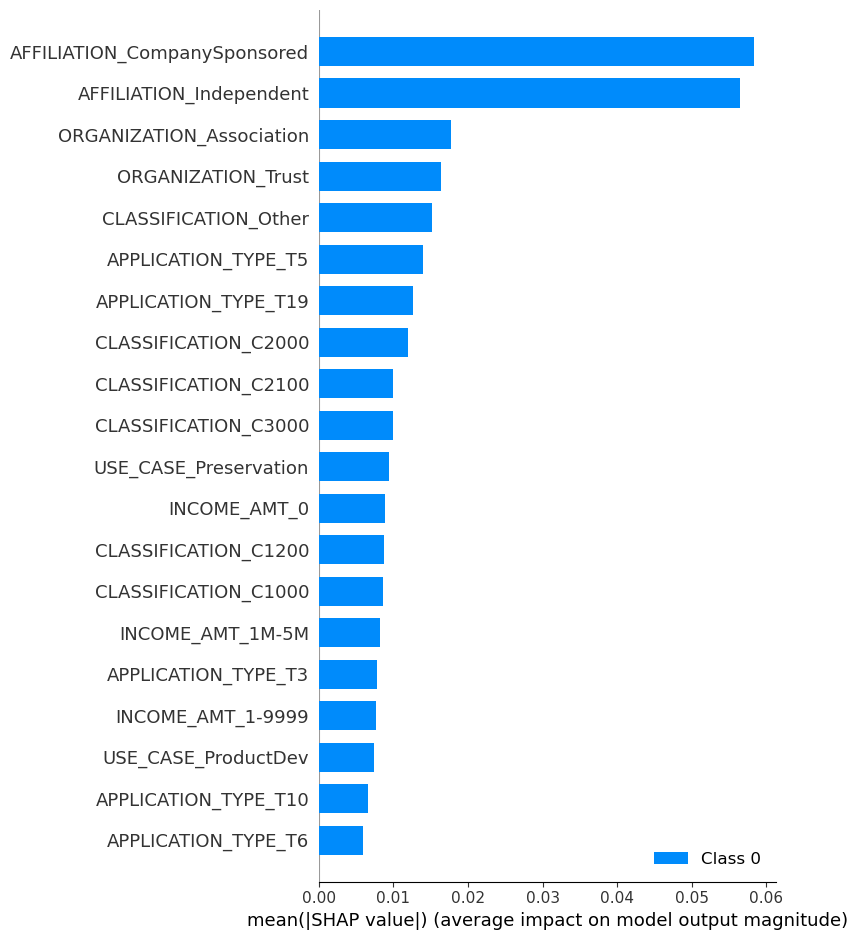

In [23]:
# %pip install shap
import shap

# create feature list
features = list(application_df.drop('IS_SUCCESSFUL', 1).columns)
# load model
model = nn_imported
# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP
explainer = shap.DeepExplainer(model,shap.sample(X_train_scaled, 1000))
shap_values = explainer.shap_values(shap.sample(X_test_scaled, 100))


# visualize the explanation
shap.summary_plot(shap_values, X_test_scaled, plot_type="bar", feature_names=features)

## 4. Rebin APPLICATION_TYPE
### Increase number of bins


In [24]:
# reload data
application_df_2 = pd.read_csv("../Resources/charity_data.csv")
# drop EIN and NAME
application_df_2 = application_df_2.drop(columns=['EIN', "NAME"])


In [25]:
# Determine which values to replace
app_type_counts = application_df_2['APPLICATION_TYPE'].value_counts()
replace_application = list(app_type_counts[app_type_counts < 100].index)
# Replace in dataframe
for app in replace_application:
    application_df_2.APPLICATION_TYPE = application_df_2.APPLICATION_TYPE.replace(app,"Other")
    
# Check to make sure binning was successful
application_df_2.APPLICATION_TYPE.value_counts()

T3       27037
T4        1542
T6        1216
T5        1173
T19       1065
T8         737
T7         725
T10        528
T9         156
Other      120
Name: APPLICATION_TYPE, dtype: int64

In [26]:
# Determine which values to replace
class_counts = application_df_2['CLASSIFICATION'].value_counts()
replace_class = list(class_counts[class_counts < 1500].index)

# Replace in dataframe
for cls in replace_class:
    application_df_2.CLASSIFICATION = application_df_2.CLASSIFICATION.replace(cls,"Other")

# Generate our categorical variable lists
application_cat = application_df_2.dtypes[application_df_2.dtypes == object].index.to_list()

# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(application_df_2[application_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names_out(application_cat)

# Merge one-hot encoded features and drop the originals
application_df_2 = application_df_2.merge(encode_df, left_index=True, right_index=True)
application_df_2 = application_df_2.drop(application_cat, 1)
application_df_2.head()

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


,STATUS,ASK_AMT,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,1,5000,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,108590,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,5000,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,6692,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,142590,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [27]:
# Split our preprocessed data into our features and target arrays
y = application_df_2['IS_SUCCESSFUL'].values
X = application_df_2.drop('IS_SUCCESSFUL', 1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [28]:
# Define the model
n_inputs = len(X_train_scaled[0])
n_nodes_layer1 = 80
n_nodes_layer2 = 30

nn_new = tf.keras.models.Sequential()

# First hidden layer
nn_new.add(tf.keras.layers.Dense(units=n_nodes_layer1, 
        input_dim=n_inputs, activation="relu"))


# Second hidden layer
nn_new.add(tf.keras.layers.Dense(units=n_nodes_layer2, 
        activation="relu"))

# Output layer
nn_new.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn_new.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 80)                3600      
                                                                 
 dense_11 (Dense)            (None, 30)                2430      
                                                                 
 dense_12 (Dense)            (None, 1)                 31        
                                                                 
Total params: 6,061
Trainable params: 6,061
Non-trainable params: 0
_________________________________________________________________


In [29]:
# Define the checkpoint path and filenames
os.makedirs("../checkpoints/trial_4",exist_ok=True)
checkpoint_path = "../checkpoints/trial_4/weights.{epoch:02d}.hdf5"

# Compile the model
nn_new.compile(loss="binary_crossentropy", optimizer="adam", 
            metrics=["accuracy"])

# Create callback to save weights per 5epochs
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=(804*5))

# Train the model
nn_new_fit = nn_new.fit(X_train_scaled,y_train,epochs=100,
        callbacks=[cp_callback])

Epoch 1/100
804/804 [==============================] - 1s 930us/step - loss: 0.5700 - accuracy: 0.7228
Epoch 2/100
804/804 [==============================] - 1s 900us/step - loss: 0.5549 - accuracy: 0.7301
Epoch 3/100
804/804 [==============================] - 1s 939us/step - loss: 0.5520 - accuracy: 0.7313
Epoch 4/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5493 - accuracy: 0.7322
Epoch 5/100
755/804 [===========================>..] - ETA: 0s - loss: 0.5480 - accuracy: 0.7315
Epoch 5: saving model to ../checkpoints/trial_4\weights.05.hdf5
804/804 [==============================] - 1s 946us/step - loss: 0.5486 - accuracy: 0.7317
Epoch 6/100
804/804 [==============================] - 1s 944us/step - loss: 0.5477 - accuracy: 0.7315
Epoch 7/100
804/804 [==============================] - 1s 894us/step - loss: 0.5464 - accuracy: 0.7330
Epoch 8/100
804/804 [==============================] - 1s 946us/step - loss: 0.5465 - accuracy: 0.7331
Epoch 9/100
804/804 [========

In [30]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn_new.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5858 - accuracy: 0.7258 - 269ms/epoch - 1ms/step
Loss: 0.5857557654380798, Accuracy: 0.7258309125900269


In [31]:
# Save the model
os.makedirs("../models/trial_4/",exist_ok=True)
nn_new.save("../models/trial_4/AlphabetSoupCharity_Optimization4.h5")

## 5. Drop APPLICATION_TYPE 

In [32]:
# Reload data
application_df_3 = pd.read_csv("../Resources/charity_data.csv")
# drop EIN and NAME, and APPLICATION_TYPE
application_df_3 = application_df_3.drop(columns=['EIN', "NAME", "APPLICATION_TYPE"])

# Determine which values to replace
class_counts = application_df_3['CLASSIFICATION'].value_counts()
replace_class = list(class_counts[class_counts < 1500].index)

# Replace in dataframe
for cls in replace_class:
    application_df_3.CLASSIFICATION = application_df_3.CLASSIFICATION.replace(cls,"Other")
    
# Get categorical features
application_cat = application_df_3.dtypes[application_df_3.dtypes == object].index.to_list()

# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(application_df_3[application_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names_out(application_cat)

# Merge one-hot encoded features and drop the originals
application_df_3 = application_df_3.merge(encode_df, left_index=True, right_index=True)
application_df_3 = application_df_3.drop(application_cat, 1)
application_df_3.head()


In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


,STATUS,ASK_AMT,IS_SUCCESSFUL,AFFILIATION_CompanySponsored,AFFILIATION_Family/Parent,AFFILIATION_Independent,AFFILIATION_National,AFFILIATION_Other,AFFILIATION_Regional,CLASSIFICATION_C1000,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,1,5000,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,108590,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,5000,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,6692,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,142590,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [33]:
# Split our preprocessed data into our features and target arrays
y = application_df_3['IS_SUCCESSFUL'].values
X = application_df_3.drop('IS_SUCCESSFUL', 1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Rebuild model and train with new data
n_inputs = len(X_train_scaled[0])
n_nodes_layer1 = 80
n_nodes_layer2 = 30

nn_new_2 = tf.keras.models.Sequential()

# First hidden layer
nn_new_2.add(tf.keras.layers.Dense(units=n_nodes_layer1, 
        input_dim=n_inputs, activation="relu"))


# Second hidden layer
nn_new_2.add(tf.keras.layers.Dense(units=n_nodes_layer2, 
        activation="relu"))

# Output layer
nn_new_2.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Define the checkpoint path and filenames
os.makedirs("../checkpoints/trial_5",exist_ok=True)
checkpoint_path = "../checkpoints/trial_5/weights.{epoch:02d}.hdf5"

# Compile the model
nn_new_2.compile(loss="binary_crossentropy", optimizer="adam", 
            metrics=["accuracy"])

# Create callback to save weights per 5epochs
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=(804*5))

# Train the model
nn_new_2_fit = nn_new_2.fit(X_train_scaled,y_train,epochs=100,
        callbacks=[cp_callback])


Epoch 1/100


In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


804/804 [==============================] - 1s 924us/step - loss: 0.5946 - accuracy: 0.6983
Epoch 2/100
804/804 [==============================] - 1s 972us/step - loss: 0.5817 - accuracy: 0.7079
Epoch 3/100
804/804 [==============================] - 1s 952us/step - loss: 0.5803 - accuracy: 0.7093
Epoch 4/100
804/804 [==============================] - 1s 989us/step - loss: 0.5772 - accuracy: 0.7085
Epoch 5/100
802/804 [============================>.] - ETA: 0s - loss: 0.5761 - accuracy: 0.7103
Epoch 5: saving model to ../checkpoints/trial_5\weights.05.hdf5
804/804 [==============================] - 1s 893us/step - loss: 0.5761 - accuracy: 0.7103
Epoch 6/100
804/804 [==============================] - 1s 973us/step - loss: 0.5755 - accuracy: 0.7102
Epoch 7/100
804/804 [==============================] - 1s 901us/step - loss: 0.5748 - accuracy: 0.7093
Epoch 8/100
804/804 [==============================] - 1s 925us/step - loss: 0.5750 - accuracy: 0.7114
Epoch 9/100
804/804 [==================

In [34]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn_new_2.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.6052 - accuracy: 0.7054 - 295ms/epoch - 1ms/step
Loss: 0.6052373051643372, Accuracy: 0.7054227590560913


In [35]:
# Save the model
os.makedirs("../models/trial_5/",exist_ok=True)
nn_new_2.save("../models/trial_5/AlphabetSoupCharity_Optimization5.h5")

## 6. Additional Neurons per Layer, Additional Layer, Filter for most important Variables, Decrease bins, stratify data split.
### VARIABLES TO KEEP : ["AFFILIATION", "ORGANIZATION", "CLASSIFICATION", "INCOME_AMT", "USE_CASE", "APPLICATION_TYPE"]

In [36]:
# Reload data
application_df_4 = pd.read_csv("../Resources/charity_data.csv")
# drop EIN and NAME, and APPLICATION_TYPE
application_df_4 = application_df_4[["IS_SUCCESSFUL", "AFFILIATION", "ORGANIZATION", 
        "CLASSIFICATION", "INCOME_AMT", "USE_CASE", "APPLICATION_TYPE"]]


# Determine which values to replace
app_type_counts = application_df_4['APPLICATION_TYPE'].value_counts()
replace_application = list(app_type_counts[app_type_counts < 1000].index)
# Replace in dataframe
for app in replace_application:
    application_df_4.APPLICATION_TYPE = application_df_4.APPLICATION_TYPE.replace(app,"Other")

class_counts = application_df_4['CLASSIFICATION'].value_counts()
replace_class = list(class_counts[class_counts < 5000].index)

# Replace in dataframe
for cls in replace_class:
    application_df_4.CLASSIFICATION = application_df_4.CLASSIFICATION.replace(cls,"Other")
    
# Get categorical features
application_cat = application_df_4.dtypes[application_df_4.dtypes == object].index.to_list()

# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(application_df_4[application_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names_out(application_cat)

# Merge one-hot encoded features and drop the originals
application_df_4 = application_df_4.merge(encode_df, left_index=True, right_index=True)
application_df_4 = application_df_4.drop(application_cat, 1)
application_df_4.head()

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


,IS_SUCCESSFUL,AFFILIATION_CompanySponsored,AFFILIATION_Family/Parent,AFFILIATION_Independent,AFFILIATION_National,AFFILIATION_Other,AFFILIATION_Regional,ORGANIZATION_Association,ORGANIZATION_Co-operative,ORGANIZATION_Corporation,...,USE_CASE_Heathcare,USE_CASE_Other,USE_CASE_Preservation,USE_CASE_ProductDev,APPLICATION_TYPE_Other,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6
0,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [37]:
# Split our preprocessed data into our features and target arrays
y = application_df_4['IS_SUCCESSFUL'].values
X = application_df_4.drop('IS_SUCCESSFUL', 1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y ,random_state=0)

# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Rebuild model and train with new data
n_inputs = len(X_train_scaled[0])
n_nodes_layer1 = 120
n_nodes_layer2 = 60
n_nodes_layer3 = 30

nn_new_3 = tf.keras.models.Sequential()

# First hidden layer
nn_new_3.add(tf.keras.layers.Dense(units=n_nodes_layer1, 
        input_dim=n_inputs, activation="relu"))


# Second hidden layer
nn_new_3.add(tf.keras.layers.Dense(units=n_nodes_layer2, 
        activation="relu"))

# Second hidden layer
nn_new_3.add(tf.keras.layers.Dense(units=n_nodes_layer3, 
        activation="relu"))

# Output layer
nn_new_3.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Define the checkpoint path and filenames
os.makedirs("../checkpoints/trial_6",exist_ok=True)
checkpoint_path = "../checkpoints/trial_6/weights.{epoch:02d}.hdf5"

# Compile the model
nn_new_3.compile(loss="binary_crossentropy", optimizer="adam", 
            metrics=["accuracy"])

# Create callback to save weights per 5epochs
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=(804*5))

# Train the model
nn_new_3_fit = nn_new_3.fit(X_train_scaled,y_train,epochs=100,
        callbacks=[cp_callback])


Epoch 1/100


In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


804/804 [==============================] - 1s 983us/step - loss: 0.5748 - accuracy: 0.7189
Epoch 2/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5634 - accuracy: 0.7269
Epoch 3/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5618 - accuracy: 0.7276
Epoch 4/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5600 - accuracy: 0.7282
Epoch 5/100
797/804 [============================>.] - ETA: 0s - loss: 0.5590 - accuracy: 0.7292
Epoch 5: saving model to ../checkpoints/trial_6\weights.05.hdf5
804/804 [==============================] - 1s 1ms/step - loss: 0.5593 - accuracy: 0.7288
Epoch 6/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5586 - accuracy: 0.7295
Epoch 7/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5581 - accuracy: 0.7301
Epoch 8/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5573 - accuracy: 0.7312
Epoch 9/100
804/804 [==============================] 

In [38]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn_new_3.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5782 - accuracy: 0.7276 - 278ms/epoch - 1ms/step
Loss: 0.578154981136322, Accuracy: 0.727580189704895


In [39]:
# Save the model
os.makedirs("../models/trial_6/",exist_ok=True)
nn_new_3.save("../models/trial_6/AlphabetSoupCharity_Optimization6.h5")

## 7. Increase number of bins CLASSIFICATION

In [40]:
# Reload data
application_df = pd.read_csv("../Resources/charity_data.csv")
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
application_df = application_df.drop(columns=['EIN', "NAME"])
# Determine which values to replace
app_type_counts = application_df['APPLICATION_TYPE'].value_counts()
replace_application = list(app_type_counts[app_type_counts < 500].index)
# Replace in dataframe
for app in replace_application:
    application_df.APPLICATION_TYPE = application_df.APPLICATION_TYPE.replace(app,"Other")
# Determine which values to replace
class_counts = application_df['CLASSIFICATION'].value_counts()
replace_class = list(class_counts[class_counts < 50].index)
# Replace in dataframe
for cls in replace_class:
    application_df.CLASSIFICATION = application_df.CLASSIFICATION.replace(cls,"Other")
application_cat = application_df.dtypes[application_df.dtypes == object].index.to_list()
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)
# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(application_df[application_cat]))
# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names_out(application_cat)
encode_df.head()
application_df = application_df.merge(encode_df, left_index=True, right_index=True)
application_df = application_df.drop(application_cat, 1)
# Split our preprocessed data into our features and target arrays
y = application_df['IS_SUCCESSFUL'].values
X = application_df.drop('IS_SUCCESSFUL', 1).values
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
# Create a StandardScaler instances
scaler = StandardScaler()
# Fit the StandardScaler
X_scaler = scaler.fit(X_train)
# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [41]:
# Rebuild model and train with new data
n_inputs = len(X_train_scaled[0])
n_nodes_layer1 = 80
n_nodes_layer2 = 30

nn_new_4 = tf.keras.models.Sequential()

# First hidden layer
nn_new_4.add(tf.keras.layers.Dense(units=n_nodes_layer1, 
        input_dim=n_inputs, activation="relu"))


# Second hidden layer
nn_new_4.add(tf.keras.layers.Dense(units=n_nodes_layer2, 
        activation="relu"))

# Output layer
nn_new_4.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Define the checkpoint path and filenames
os.makedirs("../checkpoints/trial_7",exist_ok=True)
checkpoint_path = "../checkpoints/trial_7/weights.{epoch:02d}.hdf5"

# Compile the model
nn_new_4.compile(loss="binary_crossentropy", optimizer="adam", 
            metrics=["accuracy"])

# Create callback to save weights per 5epochs
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=(804*5))

# Train the model
nn_new_4_fit = nn_new_4.fit(X_train_scaled,y_train,epochs=100,
        callbacks=[cp_callback])

Epoch 1/100
804/804 [==============================] - 1s 907us/step - loss: 0.5705 - accuracy: 0.7203
Epoch 2/100
804/804 [==============================] - 1s 926us/step - loss: 0.5525 - accuracy: 0.7317
Epoch 3/100
804/804 [==============================] - 1s 928us/step - loss: 0.5481 - accuracy: 0.7338
Epoch 4/100
804/804 [==============================] - 1s 931us/step - loss: 0.5465 - accuracy: 0.7341
Epoch 5/100
799/804 [============================>.] - ETA: 0s - loss: 0.5457 - accuracy: 0.7339
Epoch 5: saving model to ../checkpoints/trial_7\weights.05.hdf5
804/804 [==============================] - 1s 1ms/step - loss: 0.5457 - accuracy: 0.7340
Epoch 6/100
804/804 [==============================] - 1s 943us/step - loss: 0.5438 - accuracy: 0.7357
Epoch 7/100
804/804 [==============================] - 1s 907us/step - loss: 0.5435 - accuracy: 0.7355
Epoch 8/100
804/804 [==============================] - 1s 902us/step - loss: 0.5423 - accuracy: 0.7348
Epoch 9/100
804/804 [========

In [42]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn_new_4.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5746 - accuracy: 0.7264 - 285ms/epoch - 1ms/step
Loss: 0.5746257901191711, Accuracy: 0.7264139652252197


In [43]:
# Save the model
os.makedirs("../models/trial_7/",exist_ok=True)
nn_new_4.save("../models/trial_7/AlphabetSoupCharity_Optimization7.h5")

## 8. Final trial
### Keep previously dropped NAME column and apply binning, Apply binning to ASK_AMT column, Change scaling, Add layer, Increase Neurons.

In [13]:
#
## Reload original data
#
application_df = pd.read_csv("../Resources/charity_data.csv")
# Drop the non-beneficial ID columns, 'EIN'
application_df = application_df.drop(columns=['EIN'])

# Make bins for APPLICATION_TYPE, CLASSISFICATION, NAME

# Determine which values to replace
app_type_counts = application_df['APPLICATION_TYPE'].value_counts()
replace_application = list(app_type_counts[app_type_counts < 500].index)
# Replace in dataframe
for app in replace_application:
    application_df.APPLICATION_TYPE = application_df.APPLICATION_TYPE.replace(app,"Other")

# Determine which values to replace
class_counts = application_df['CLASSIFICATION'].value_counts()
replace_class = list(class_counts[class_counts < 1500].index)
# Replace in dataframe
for cls in replace_class:
    application_df.CLASSIFICATION = application_df.CLASSIFICATION.replace(cls,"Other")



#
## Change 1. Bin newly kept name column and ask_amt column
#
# Determine which values to replace
name_counts = application_df["NAME"].value_counts()
replace_name = list(name_counts[name_counts < 20].index)
# Replace in dataframe
for name in replace_name:
    application_df.NAME = application_df.NAME.replace(name,'Other')

# Determine which values to replace
ask_amt_counts = list(application_df.ASK_AMT.value_counts().index)
for amt in ask_amt_counts:
    if amt <= 5000:
        application_df.ASK_AMT = application_df.ASK_AMT.replace(amt, 'Less than 5000')
    elif 5000 < amt <= 15000:
        application_df.ASK_AMT = application_df.ASK_AMT.replace(amt, 'Between 5000 and 15000')
    elif 15000 < amt <= 25000:
        application_df.ASK_AMT = application_df.ASK_AMT.replace(amt, 'Between 15000 and 25000')
    else:
        application_df.ASK_AMT = application_df.ASK_AMT.replace(amt, 'Greater than 25000')

#
## encode categorical features
# select categorical columns
application_cat = application_df.dtypes[application_df.dtypes == object].index.to_list()
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)
# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(application_df[application_cat]))
# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names_out(application_cat)
# merge encoded features with application_df, drop original columns
application_df = application_df.merge(encode_df, left_index=True, right_index=True)
application_df = application_df.drop(application_cat, 1)
# Split our preprocessed data into our features and target arrays
y = application_df['IS_SUCCESSFUL'].values
X = application_df.drop('IS_SUCCESSFUL', 1).values
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

c:\Users\jacob\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:60: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
c:\Users\jacob\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:63: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [14]:
#
## Change 2. Use MinMaxScaler
#
# Create the Scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# Fit the Scaler
X_scaler = scaler.fit(X_train)
# Scale data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

#
## Change 3. Increase Neurons to [2, 1, .5 ] times features in each layer
# 
n_inputs = len(X_train_scaled[0])
n_nodes_layer1 = n_inputs * 2
n_nodes_layer2 = n_inputs
n_nodes_layer3 = n_inputs * .5
n_nodes_layer4 = 15

# Rebuild model and train with new data
#
# create model
nn_n = tf.keras.models.Sequential()

# First hidden layer
nn_n.add(tf.keras.layers.Dense(units=n_nodes_layer1, 
        input_dim=n_inputs, activation="relu"))

# Second hidden layer
nn_n.add(tf.keras.layers.Dense(units=n_nodes_layer2, activation="relu"))

#
## Change 4. Add Third layer
#
nn_n.add(tf.keras.layers.Dense(units=n_nodes_layer3, activation="relu"))

# Output layer
nn_n.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Compile the model
nn_n.compile(loss="binary_crossentropy", optimizer="adam", 
            metrics=["accuracy"])

print(nn_n.summary())



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 336)               56784     
                                                                 
 dense_13 (Dense)            (None, 168)               56616     
                                                                 
 dense_14 (Dense)            (None, 84)                14196     
                                                                 
 dense_15 (Dense)            (None, 1)                 85        
                                                                 
Total params: 127,681
Trainable params: 127,681
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
# Define the checkpoint path and filenames
os.makedirs("../checkpoints/trial_8",exist_ok=True)
checkpoint_path = "../checkpoints/trial_8/weights.{epoch:02d}.hdf5"

# Create callback to save weights per 5epochs
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=(804*5))

# Train the model, increase
nn_n_fit = nn_n.fit(X_train_scaled,y_train,epochs=100,
        callbacks=[cp_callback])
        
model_loss, model_accuracy = nn_n.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")


Epoch 1/100
804/804 [==============================] - 2s 2ms/step - loss: 0.4881 - accuracy: 0.7576
Epoch 2/100
804/804 [==============================] - 2s 2ms/step - loss: 0.4601 - accuracy: 0.7727
Epoch 3/100
804/804 [==============================] - 2s 2ms/step - loss: 0.4551 - accuracy: 0.7754
Epoch 4/100
804/804 [==============================] - 2s 2ms/step - loss: 0.4532 - accuracy: 0.7777
Epoch 5/100
783/804 [============================>.] - ETA: 0s - loss: 0.4511 - accuracy: 0.7789
Epoch 5: saving model to ../checkpoints/trial_8\weights.05.hdf5
804/804 [==============================] - 2s 2ms/step - loss: 0.4509 - accuracy: 0.7787
Epoch 6/100
804/804 [==============================] - 2s 2ms/step - loss: 0.4495 - accuracy: 0.7800
Epoch 7/100
804/804 [==============================] - 2s 2ms/step - loss: 0.4478 - accuracy: 0.7800
Epoch 8/100
804/804 [==============================] - 2s 2ms/step - loss: 0.4461 - accuracy: 0.7813
Epoch 9/100
804/804 [======================

In [16]:
# show accuracy on test data
model_loss, model_accuracy = nn_n.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 1s - loss: 0.5923 - accuracy: 0.7736 - 611ms/epoch - 2ms/step
Loss: 0.5922904014587402, Accuracy: 0.7736443281173706


In [17]:
# Save the model
os.makedirs("../models/optimized_model/",exist_ok=True)
nn_n.save("../models/optimized_model/AlphabetSoupCharity_Optimization.h5")

## TESTING

### There are considerable number of repeat applicants
### ASK_AMT column is noisy, apply binning to increase signal

In [7]:
application_df = pd.read_csv("../Resources/charity_data.csv")
application_df.isnull().sum()

EIN                       0
NAME                      0
APPLICATION_TYPE          0
AFFILIATION               0
CLASSIFICATION            0
USE_CASE                  0
ORGANIZATION              0
STATUS                    0
INCOME_AMT                0
SPECIAL_CONSIDERATIONS    0
ASK_AMT                   0
IS_SUCCESSFUL             0
dtype: int64

<AxesSubplot:ylabel='Density'>

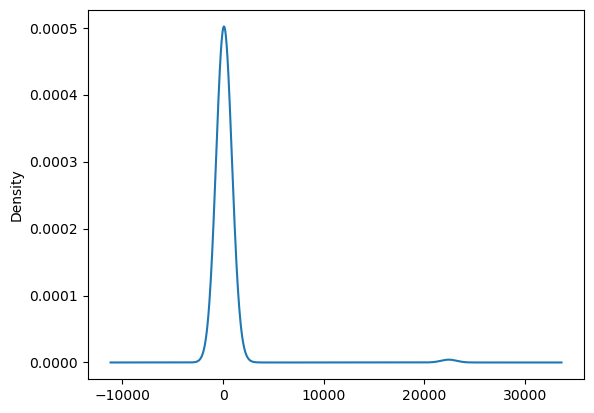

In [50]:
import matplotlib.pyplot as plt
# keeping the name column and binning
name_counts = application_df["NAME"].value_counts()
replace_name = list(name_counts[name_counts < 20].index)
for name in replace_name:
    application_df.NAME = application_df.NAME.replace(name,'Other')
name_groups = application_df.groupby(['NAME'])['NAME'].count()
name_groups.plot.density()

In [69]:
pd.Series(application_df["NAME"].value_counts()).head(50)

PARENT BOOSTER USA INC                                                1260
TOPS CLUB INC                                                          765
UNITED STATES BOWLING CONGRESS INC                                     700
WASHINGTON STATE UNIVERSITY                                            492
AMATEUR ATHLETIC UNION OF THE UNITED STATES INC                        408
PTA TEXAS CONGRESS                                                     368
SOROPTIMIST INTERNATIONAL OF THE AMERICAS INC                          331
ALPHA PHI SIGMA                                                        313
TOASTMASTERS INTERNATIONAL                                             293
MOST WORSHIPFUL STRINGER FREE AND ACCEPTED MASONS                      287
LITTLE LEAGUE BASEBALL INC                                             277
INTERNATIONAL ASSOCIATION OF LIONS CLUBS                               266
MOMS CLUB                                                              210
INTERNATIONAL ASSOCIATION

Creating bins for ask amt:
1. less than 5,000
2. 5,000 to 15,000
3. 15,000 to 25,000
4. 25,000 to 35,000

<AxesSubplot:ylabel='Density'>

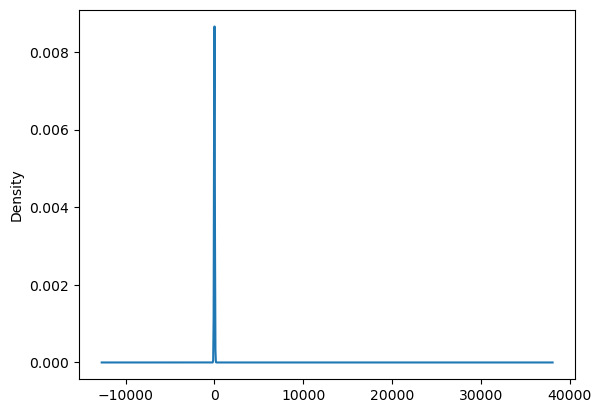

In [51]:

ask_amt_counts = application_df['ASK_AMT'].value_counts()
ask_amt_counts.plot.density()


In [11]:
# Reload data
application_df = pd.read_csv("../Resources/charity_data.csv")
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
application_df = application_df.drop(columns=['EIN'])
# Determine which values to replace
app_type_counts = application_df['APPLICATION_TYPE'].value_counts()
replace_application = list(app_type_counts[app_type_counts < 500].index)
# Replace in dataframe
for app in replace_application:
    application_df.APPLICATION_TYPE = application_df.APPLICATION_TYPE.replace(app,"Other")
# Determine which values to replace
class_counts = application_df['CLASSIFICATION'].value_counts()
replace_class = list(class_counts[class_counts < 1500].index)
# Replace in dataframe
for cls in replace_class:
    application_df.CLASSIFICATION = application_df.CLASSIFICATION.replace(cls,"Other")

# keeping the name column and binning
name_counts = application_df["NAME"].value_counts()
replace_name = list(name_counts[name_counts < 50].index)
for name in replace_name:
    application_df.NAME = application_df.NAME.replace(name,'Other')

# binning the ask_amt column
ask_amt_counts = list(application_df.ASK_AMT.value_counts().index)
for amt in ask_amt_counts:
    if amt <= 5000:
        application_df.ASK_AMT = application_df.ASK_AMT.replace(amt, 'Less than 5000')
    elif 5000 < amt <= 10000:
        application_df.ASK_AMT = application_df.ASK_AMT.replace(amt, 'Between 5000 and 10000')
    elif 10000 < amt <= 15000:
        application_df.ASK_AMT = application_df.ASK_AMT.replace(amt, 'Between 10000 and 15000')   
    elif 15000 < amt <= 20000:
        application_df.ASK_AMT = application_df.ASK_AMT.replace(amt, 'Between 15000 and 20000')
    elif 20000 < amt <= 25000:
        application_df.ASK_AMT = application_df.ASK_AMT.replace(amt, 'Between 20000 and 25000')
    elif 25000 < amt <= 30000:
        application_df.ASK_AMT = application_df.ASK_AMT.replace(amt, 'Between 25000 and 30000')
    else:
        application_df.ASK_AMT = application_df.ASK_AMT.replace(amt, 'Greater than 30000')

print(application_df['ASK_AMT'].value_counts())
# application_df = application_df[['IS_SUCCESSFUL',"AFFILIATION", "ORGANIZATION", "CLASSIFICATION", "ASK_AMT", "USE_CASE", "APPLICATION_TYPE", "INCOME_AMT"]]

application_cat = application_df.dtypes[application_df.dtypes == object].index.to_list()
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)
# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(application_df[application_cat]))
# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names_out(application_cat)
encode_df.head()
application_df = application_df.merge(encode_df, left_index=True, right_index=True)
application_df = application_df.drop(application_cat, 1)
# Split our preprocessed data into our features and target arrays
y = application_df['IS_SUCCESSFUL'].values
X = application_df.drop('IS_SUCCESSFUL', 1).values
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y)


# # Create a StandardScaler instances
# scaler = StandardScaler()
# # Fit the StandardScaler
# X_scaler = scaler.fit(X_train)
# # Scale the data
# X_train_scaled = X_scaler.transform(X_train)
# X_test_scaled = X_scaler.transform(X_test)


from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

print(len(X_train_scaled[0]))
# Rebuild model and train with new data
n_inputs = len(X_train_scaled[0])
n_nodes_layer1 = n_inputs * 2
n_nodes_layer2 = n_inputs
n_nodes_layer3 = n_inputs * .5
n_nodes_layer4 = 15

from keras.layers import LeakyReLU, ELU, PReLU, ThresholdedReLU, ReLU

nn_n = tf.keras.models.Sequential()

# First hidden layer
nn_n.add(tf.keras.layers.Dense(units=n_nodes_layer1, 
        input_dim=n_inputs, activation="relu"))
# nn_n.add(ReLU())

# regularizer = tf.keras.regularizers.OrthogonalRegularizer(factor=0.01)
# Second hidden layer
nn_n.add(tf.keras.layers.Dense(units=n_nodes_layer2, activation="relu"))
# nn_n.add(ReLU())

nn_n.add(tf.keras.layers.Dense(units=n_nodes_layer3, activation="relu"))
# nn_n.add(ReLU())

# nn_n.add(tf.keras.layers.Dense(units=n_nodes_layer4))
# nn_n.add(ReLU())

# Output layer
nn_n.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# customize optimizer
# opt = tf.keras.optimizers.Adam(learning_rate=0.03)

# Compile the model
nn_n.compile(loss="binary_crossentropy", optimizer="adam", 
            metrics=["accuracy"])

print(nn_n.summary())

# Train the model
nn_nfit = nn_n.fit(X_train_scaled,y_train,epochs=100)



Less than 5000             25398
Greater than 30000          6908
Between 5000 and 10000       549
Between 15000 and 20000      402
Between 10000 and 15000      387
Between 20000 and 25000      346
Between 25000 and 30000      309
Name: ASK_AMT, dtype: int64
101
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 202)               20604     
                                                                 
 dense_9 (Dense)             (None, 101)               20503     
                                                                 
 dense_10 (Dense)            (None, 50)                5100      
                                                                 
 dense_11 (Dense)            (None, 1)                 51        
                                                                 
Total params: 46,258
Trainable params: 46,258
Non-train

c:\Users\jacob\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
c:\Users\jacob\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:57: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


804/804 [==============================] - 2s 2ms/step - loss: 0.5030 - accuracy: 0.7473
Epoch 2/100
804/804 [==============================] - 1s 2ms/step - loss: 0.4813 - accuracy: 0.7599
Epoch 3/100
804/804 [==============================] - 1s 2ms/step - loss: 0.4772 - accuracy: 0.7634
Epoch 4/100
804/804 [==============================] - 1s 2ms/step - loss: 0.4749 - accuracy: 0.7662
Epoch 5/100
804/804 [==============================] - 1s 2ms/step - loss: 0.4731 - accuracy: 0.7673
Epoch 6/100
804/804 [==============================] - 1s 2ms/step - loss: 0.4716 - accuracy: 0.7671
Epoch 7/100
804/804 [==============================] - 1s 2ms/step - loss: 0.4708 - accuracy: 0.7683
Epoch 8/100
804/804 [==============================] - 1s 2ms/step - loss: 0.4689 - accuracy: 0.7683
Epoch 9/100
804/804 [==============================] - 1s 2ms/step - loss: 0.4679 - accuracy: 0.7703
Epoch 10/100
804/804 [==============================] - 1s 2ms/step - loss: 0.4665 - accuracy: 0.7708
E

In [12]:
model_loss, model_accuracy = nn_n.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.6572 - accuracy: 0.7655 - 463ms/epoch - 2ms/step
Loss: 0.6571705937385559, Accuracy: 0.7654810547828674
